## Lab 8 Part III: Plotting Contoured Upper-Air Data
<br /><br />

In this part of the tutorial, we plot GFS model-derived isohypses, color-filled isotachs, and wind barbs at 300 hPa.  Most of the code in this notebook has been completed, but watch out for a few areas where you are asked to complete the code.
<br />
### Module Documentation

1. Xarray Dataset: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html
2. Matplotlib Pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
3. Caropy crs: https://scitools.org.uk/cartopy/docs/latest/reference/crs.html
4. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
5. Matplotlib Colors: https://matplotlib.org/stable/gallery/color/named_colors.html
6. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
7. Matplotlib Barbs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barbs.html
8. Scipy Gaussian Filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
9. Xarray with MetPy: https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html



If you have any questions about the code below, feel free to reach out to me at mpvossen@uwm.edu. I am always willing to further explain the code. <br /> <br />

---

<br />
1. As usual, we start by importing the modules we need for our Python code.

In [1]:
#from the dates and time code(datetime), import the date and time reading capabilities (datetime)
from datetime import datetime

#import the module numpy and save it to np
import numpy as np

#import the cartopy (cartopy) module's coordinate reference system (.crs) and save it to the variable crs
import cartopy.crs as crs

#import the cartopy (cartopy) module's ability to plot geographic data (.feature) and save it to the variable cfeature 
import cartopy.feature as cfeature

#import the pyplot submodule from the matplotlib module
import matplotlib.pyplot as plt

#from the scipy module's ndimage submodule, import the function gaussian_filter
from scipy.ndimage import gaussian_filter

#import the module xarray and save it to xr
import xarray as xr

#from the metpy submodule units import the units function
from metpy.units import units

#import the calculation submodule form the metpy module and save it to the variable calc
import metpy.calc as calc

#import the pandas module and save it to the variable pd
import pandas as pd

<br /><br />
2. The code block below establishes the data processing function.  This data processing function opens GFS analysis data, converts the data's units, and computes the wind speed.

In [3]:
"""
This function retrieves and processes upper-air data.  This function opens GFS analysis data,
retains only data from a desired pressure level, converts temperature and wind units, and
computes wind speed.


INPUT:
    level : INTEGER
        The level in hPa at which you want upper-air data.
    time : DATETIME
        The time at which you would like upper-air data.
    
OUTPUT:

    model_data : XARRAY DATASET
        The xarray containing your processed GFS analysis data

"""

def process_upper_air_data(time, level):
    """
    Specify the location of the upper-air data on the JupyterHub.
    """
    lab_data_loc = "/data/AtmSci360/Lab_8/"
    
    """
    Open the GFS data using xarray.  Since the data are once again GRIB-formatted data, we can use xarray the same way we did in Lab 4.
    The data file name is still formatted %m%d%y_%H.grib2.  Only open the variables with a vertical coordinate of isobaricInhPa.
    """
    model_data = xr.open_dataset(f"{lab_data_loc}{time:%m%d%y_%H}_gfs.grib2", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
    model_data = model_data.sel(isobaricInhPa = level)
    
    """
    Our temperature (t) is in Kelvin and our winds are in m/s.  To make this easier for to use, 
    convert temperature to Celsius, the wind components to knots, and save each variable back to the xarray.
    """
    model_data['t'] = model_data["t"].metpy.convert_units('degC')
    model_data['u'] = model_data["u"].metpy.convert_units('kt')
    model_data['v'] = model_data["v"].metpy.convert_units('kt')
    
    
    """
    We want color-filled isotachs, requiring us to compute the wind speed.
    """
    wind_mag = ((model_data["u"] ** 2) + (model_data["v"] ** 2))  ** 0.5
    
    """
    To keep everything in one place, we can add the computed wind speed variable to the xarray.
    """
    model_data = model_data.assign(wind_mag=wind_mag)
    
    
    """
    Finally, have the function return the processed data.
    """
    return model_data




<br /><br />
3. Run the data processing function to get data at 300 hPa on January 5th, 2022 at 0000 UTC.

In [4]:
time=datetime(2022,1,5,0)
level=300
model_data=process_upper_air_data(time,level)

Ignoring index file '/data/AtmSci360/Lab_8/010522_00_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850

<br /><br />
4. Now that we have the data we need, we are ready to plot.  In the function below, we create a plot of isohypses, color-filled isotachs, and wind barbs at 300 hPa.  Watch out in the comments for areas you need to fill in.

In [5]:
"""
Below, a function is defined to plot upper-air geopotential heights (line contour), wind magnitude (color filled contour), and wind (barbs) at 300 hPa. 


INPUT:
    model_data : XARRAY DATASET
        The GFS analysis data.
    level : INTEGER
        The level for which the plot is valid.
    data : DATETIME
        The date and time for which the plot is valid.

"""


def gfs_temp_upper_air_plot(model_data, date):
    
    
    """
    Setup a Lambert Conic Conformal Projection centered at 35°N and 95°W.  Have the cone of the Lambert Conic Conformal projection intersect the Earth at 27.5°N and 42.5°N.
    """
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
    """
    Create a figure with a size of 1150px x 800px and a resolution of 300 dots per inch,
    then set up an axes object (named ax) using the projection we previously defined for our map.
    """
    fig = plt.figure(figsize=(11.5,8),dpi=300)
    ax = plt.subplot(projection = proj)
    
    """
    Add geographic data to our map.
    """
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=2)
        
    """
    Limit the map to between 125°-65°W longitude and 25°-60°N latitude.
    """
    ax.set_extent([-125,-65,25,60], crs=crs.PlateCarree())
    
    """   
    Set up a Gaussian filter for the geopotential heights ('gh').
    """
    smooth_heights = gaussian_filter(model_data['gh'].values, 2)
    
    
    """
    Contour and label the smoothed geopotential heights. 
    """
    cont_p = plt.contour(model_data["longitude"].values, model_data["latitude"].values, smooth_heights, np.arange(0,10000,60), colors='k', linewidths=0.85, transform=crs.PlateCarree())
    ax.clabel(cont_p, cont_p.levels, inline=True, fmt=lambda v: format(v, '.0f'), fontsize=6)
    
    """
    Create a Gaussian filter to smooth the wind-speed data.
    """
    smooth_wind = gaussian_filter(model_data['wind_mag'].values, 2)
    
    """
    Use color-filled isopleths for the wind speed. 
    """
    cont_w = plt.contourf(model_data["longitude"].values, model_data["latitude"].values, smooth_wind, np.arange(50,210,25), cmap="twilight",  transform=crs.PlateCarree(), extend="max", alpha=0.6)
    
    """
    Add a color bar with a label to show that the color-filled contours represent wind speed in knots.
    """
    cbar = plt.colorbar(cont_w)
    cbar.set_label("Wind Speed (kt)", size=12, weight="bold")
    
    """
    Set up the wind slice to skip every 12 data points in each direction.
    """
    wind_slice_x = slice(None, None, 12)
    wind_slice_y = slice(None, None, 12)
    
    
    """
    Plot wind barbs using the wind slice we create before.
    """
    ax.barbs(model_data["longitude"][wind_slice_x].values, model_data["latitude"][wind_slice_y].values,
             model_data["u"][wind_slice_x, wind_slice_y].values,
             model_data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    
    
    """
    Add an appropriate title to your plot.
    """ 
    plt.title(f"{level}hpa Oberservations, Geopotential Height (black| dm), Wind (shaded| kt)",size=7,weight="bold",loc="left")            
    plt.title(f"Valid: {time:%m/%d/%Y %H%M} UTC", size=6, loc="right")          
    
    
    
    
    plt.show()


<br /><br />
5. Call the plotting function using the data we retrieved before.

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iterati

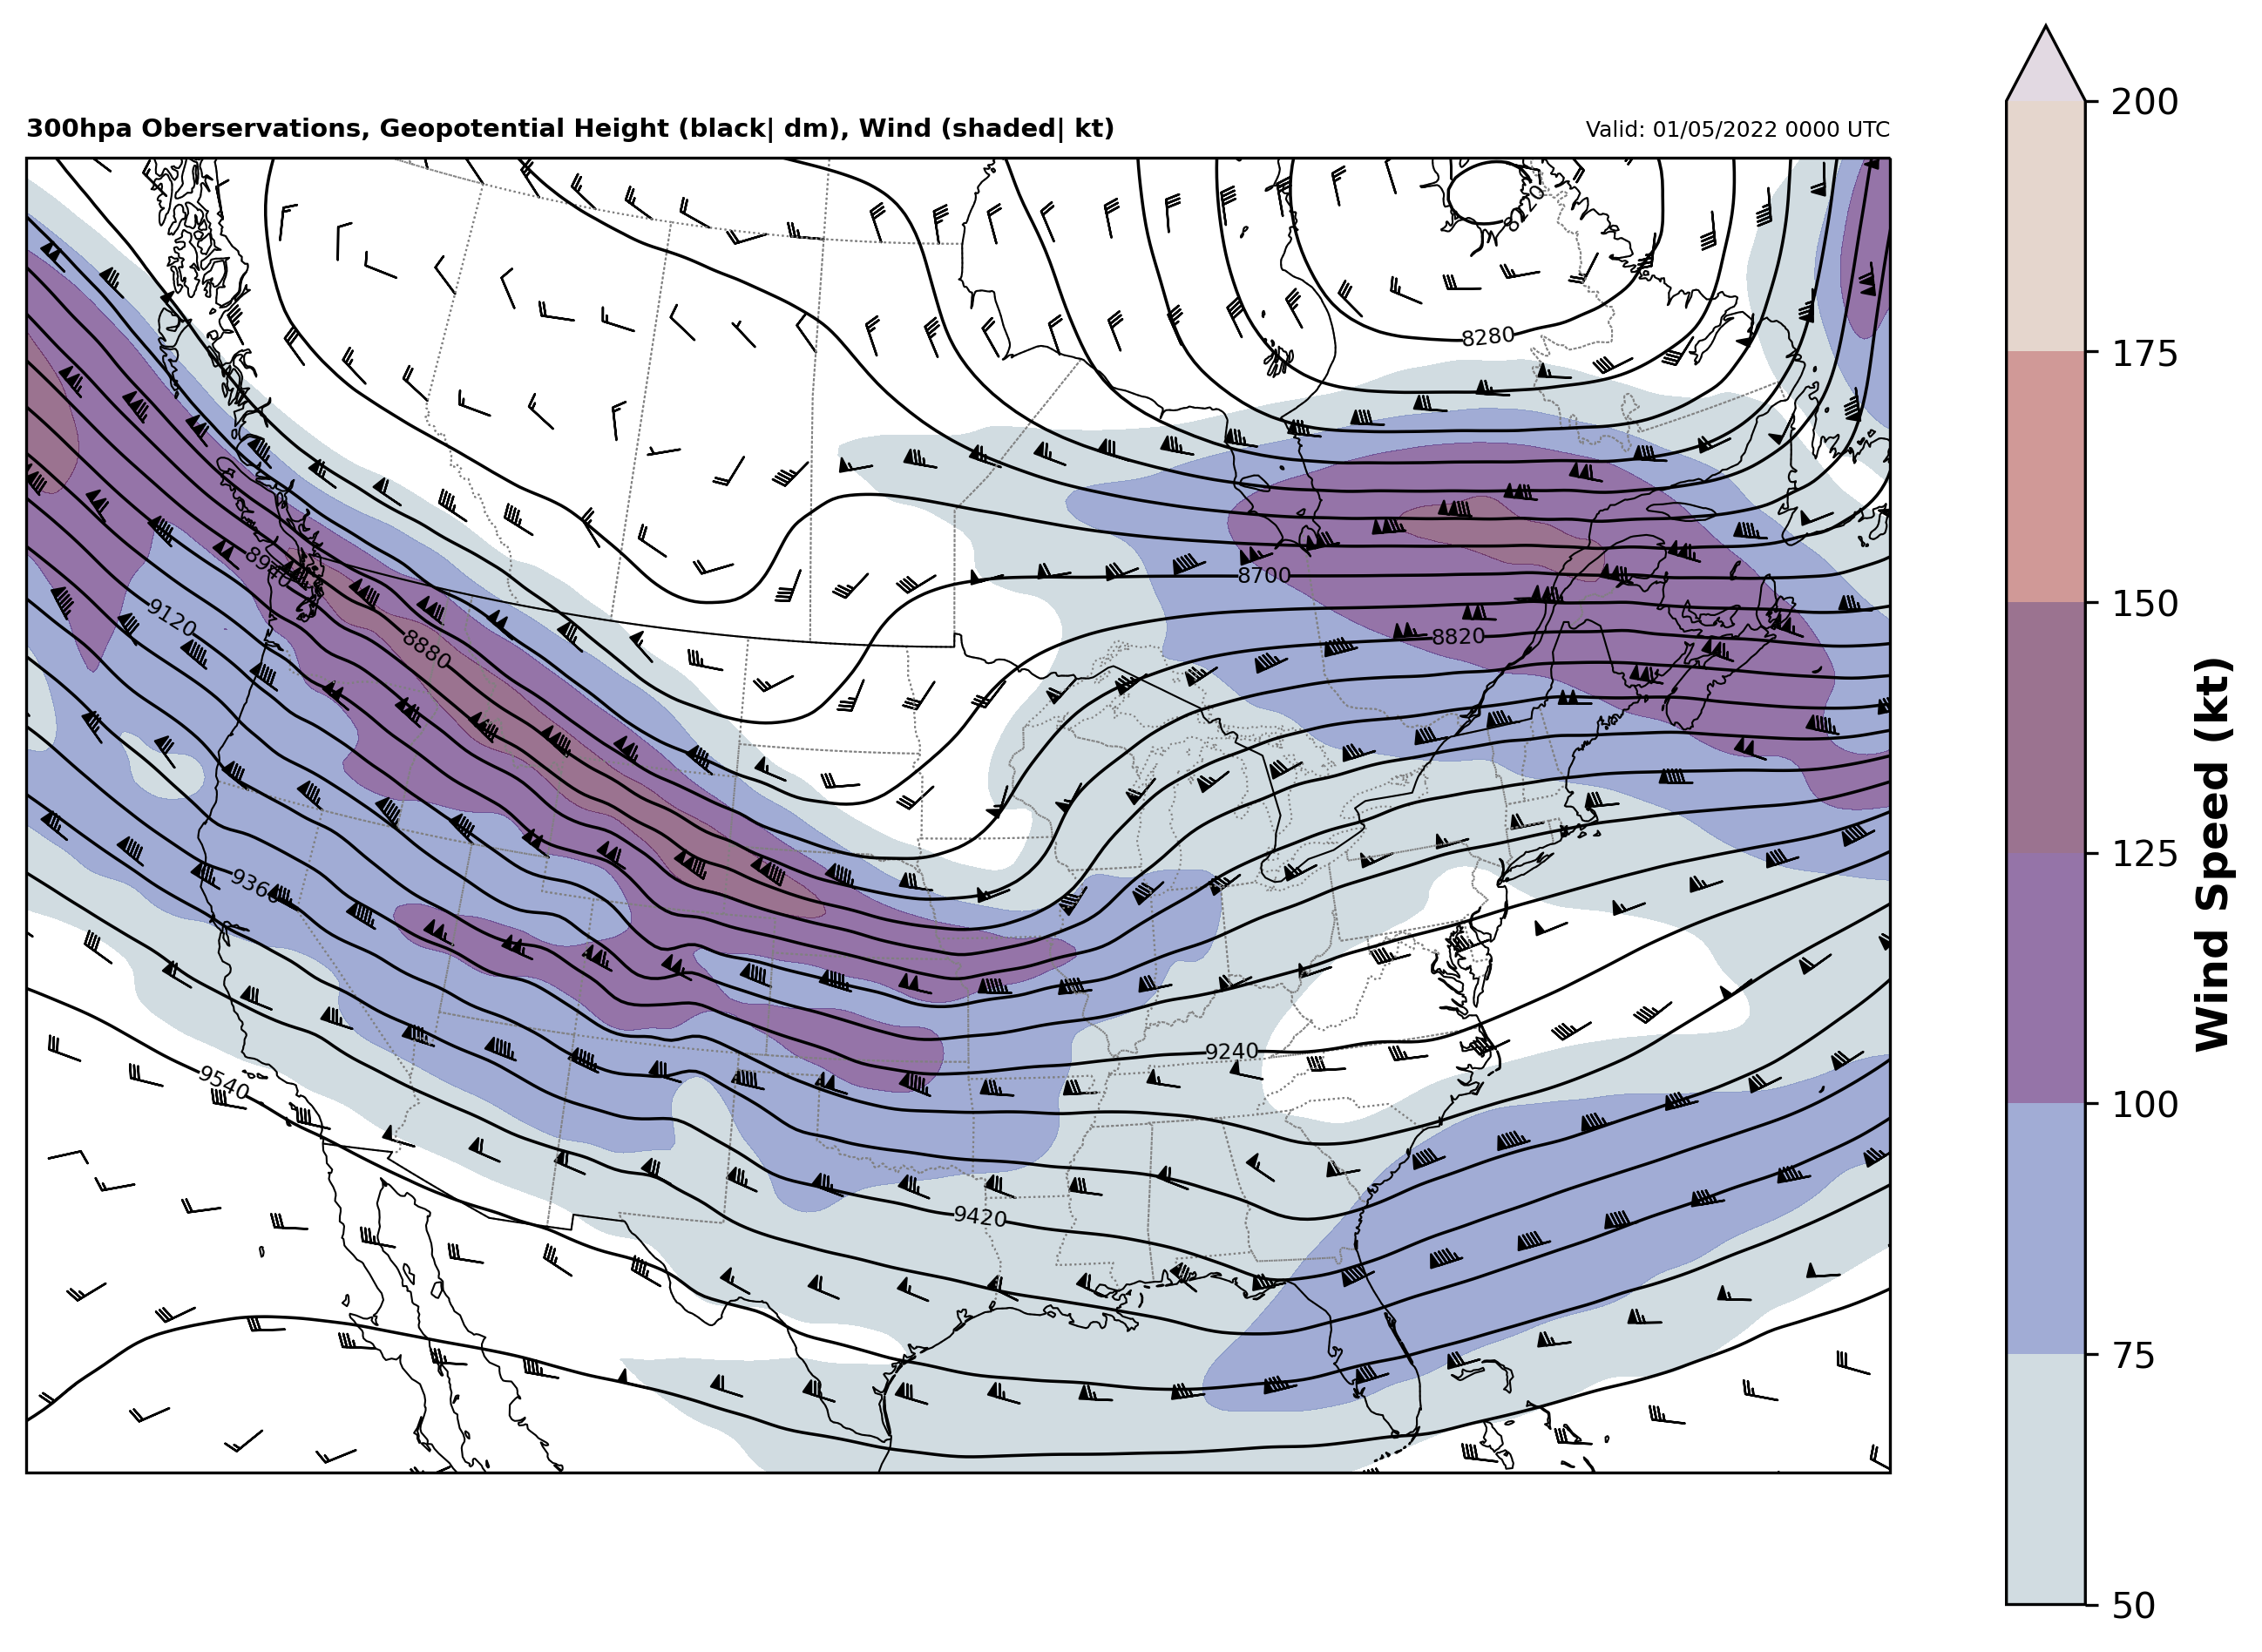

In [6]:
gfs_temp_upper_air_plot(model_data, time)

### You have now completed the Python portion of the lab.  Be sure to submit the fully rendered Jupyter Notebook on GitHub when you are finished.